In [55]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt


/home/nwertheim/miniconda3/bin/python


In [56]:
data_file = os.path.join(univariate_data_path, 'merged_univariate.npy')
data = np.load(data_file, allow_pickle=True)
print(data.shape)

# Check for NaN or Inf values in signals
for sample in data:
    if np.isnan(sample['signal']).any() or np.isinf(sample['signal']).any():
        print(f"NaN or Inf detected in {sample['record_name']}")


print(data[0]['signal'].shape)
print(data[0])



(666,)
(7600, 1)
{'record_name': 'ice001_l_1of1', 'signal': array([[-1.7358303 ],
       [-0.30347557],
       [-0.40749874],
       ...,
       [-3.09738299],
       [-2.90981482],
       [-3.22768386]]), 'metadata': {'fs': 20, 'sig_len': 100000, 'n_sig': 16, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'comments': ['Info:', 'ID:ice001', 'Record type:labour', 'Record number:1/1', 'Age(years):31', 'BMI before pregnancy:23.3', 'BMI at recording:27.6', 'Gravidity:3', 'Parity:2', 'Previous caesarean:No', 'Placental position:Fundus', 'Gestational age at recording(w/d):39/3', 'Gestational age at delivery:39/3', 'Mode of delivery:Vaginal', 'Synthetic oxytocin use in labour:No', 'Epidural during labour:No', 'Comments for recording:', 'Electrodes placed 5-10 mins prior to beginning of recording.', 'Baby born 20 minutes after the end of the recording.']}}


In [57]:
import numpy as np
import pandas as pd

# Function to create time windows from the signal data
def create_time_windows(data, window_length=12000, step_size=12000):
    """
    Create sliding windows of a specified length and step size from a list of signals.

    Args:
        data: list of dicts, each containing a 'signal' array of shape (seq_len, 1)
        window_length: number of time steps in each window
        step_size: number of time steps to move between windows (for overlap)

    Returns:
        np.ndarray: shape (num_windows, window_length), univariate windows
    """
    windows = []

    for entry in data:
        signal = entry['signal'].flatten()  # shape: (seq_len,)
        signal_length = len(signal)

        if signal_length < window_length:
            continue

        for start_idx in range(0, signal_length - window_length + 1, step_size):
            end_idx = start_idx + window_length
            window = signal[start_idx:end_idx]
            windows.append(window)

    return np.array(windows)  # shape: (num_windows, window_length)


windows = create_time_windows(data)
print(windows.shape)
print(windows[0].shape)

(1550, 12000)
(12000,)


In [58]:
import numpy as np
from sklearn.model_selection import train_test_split

def split_data(windows, test_size=0.1, val_size=0.1, random_seed=42):
    """
    Splits the dataset into training, validation, and test sets with specified proportions.
    
    Parameters:
    - windows (numpy.ndarray): The dataset to split, shaped as (num_samples, window_size).
    - test_size (float): Proportion of data to be used for the test set.
    - val_size (float): Proportion of data to be used for the validation set.
    - random_seed (int): Seed for reproducibility.

    Returns:
    - X_train, X_val, X_test: The splits of the dataset.
    """
    # First, split into train and temp (test + validation)
    X_train, X_temp = train_test_split(windows, test_size=(test_size + val_size), random_state=random_seed)
    
    # Then, split the temp into validation and test
    val_size_adjusted = val_size / (val_size + test_size)  # Adjust to split remaining temp
    X_val, X_test = train_test_split(X_temp, test_size=val_size_adjusted, random_state=random_seed)
    
    return X_train, X_val, X_test

# Example usage with your windows data
X_train, X_val, X_test = split_data(windows, test_size=0.1, val_size=0.1)

# Check the shapes of the splits
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (1240, 12000)
Validation set shape: (155, 12000)
Test set shape: (155, 12000)


In [59]:
def mask_data(x, mask_ratio=0.5, patch_size=8):
    """
    Apply patch-based masking to a batch of univariate time series.

    Args:
        x: np.ndarray of shape (num_windows, window_length)
        mask_ratio: float, fraction of patches to mask
        patch_size: int, number of time steps in each patch

    Returns:
        np.ndarray: masked version of x with same shape
    """
    x_masked = np.copy(x)
    num_windows, window_length = x.shape
    num_patches = window_length // patch_size

    for i in range(num_windows):
        mask = np.random.rand(num_patches) < mask_ratio
        for j in range(num_patches):
            if mask[j]:
                start = j * patch_size
                end = (j + 1) * patch_size
                x_masked[i, start:end] = 0  # or np.nan if you prefer

    return x_masked

# Apply masking to train, validation, and test sets
mask_ratio = 0.2  # Adjust this to your desired masking ratio
masked_X_train = apply_masking(X_train, mask_ratio)
masked_X_val = apply_masking(X_val, mask_ratio)
masked_X_test = apply_masking(X_test, mask_ratio)

# Check the shape of the masked datasets
print(f"Masked Training set shape: {masked_X_train.shape}")
print(f"Masked Validation set shape: {masked_X_val.shape}")
print(f"Masked Test set shape: {masked_X_test.shape}")

Masked Training set shape: (1240, 12000)
Masked Validation set shape: (155, 12000)
Masked Test set shape: (155, 12000)


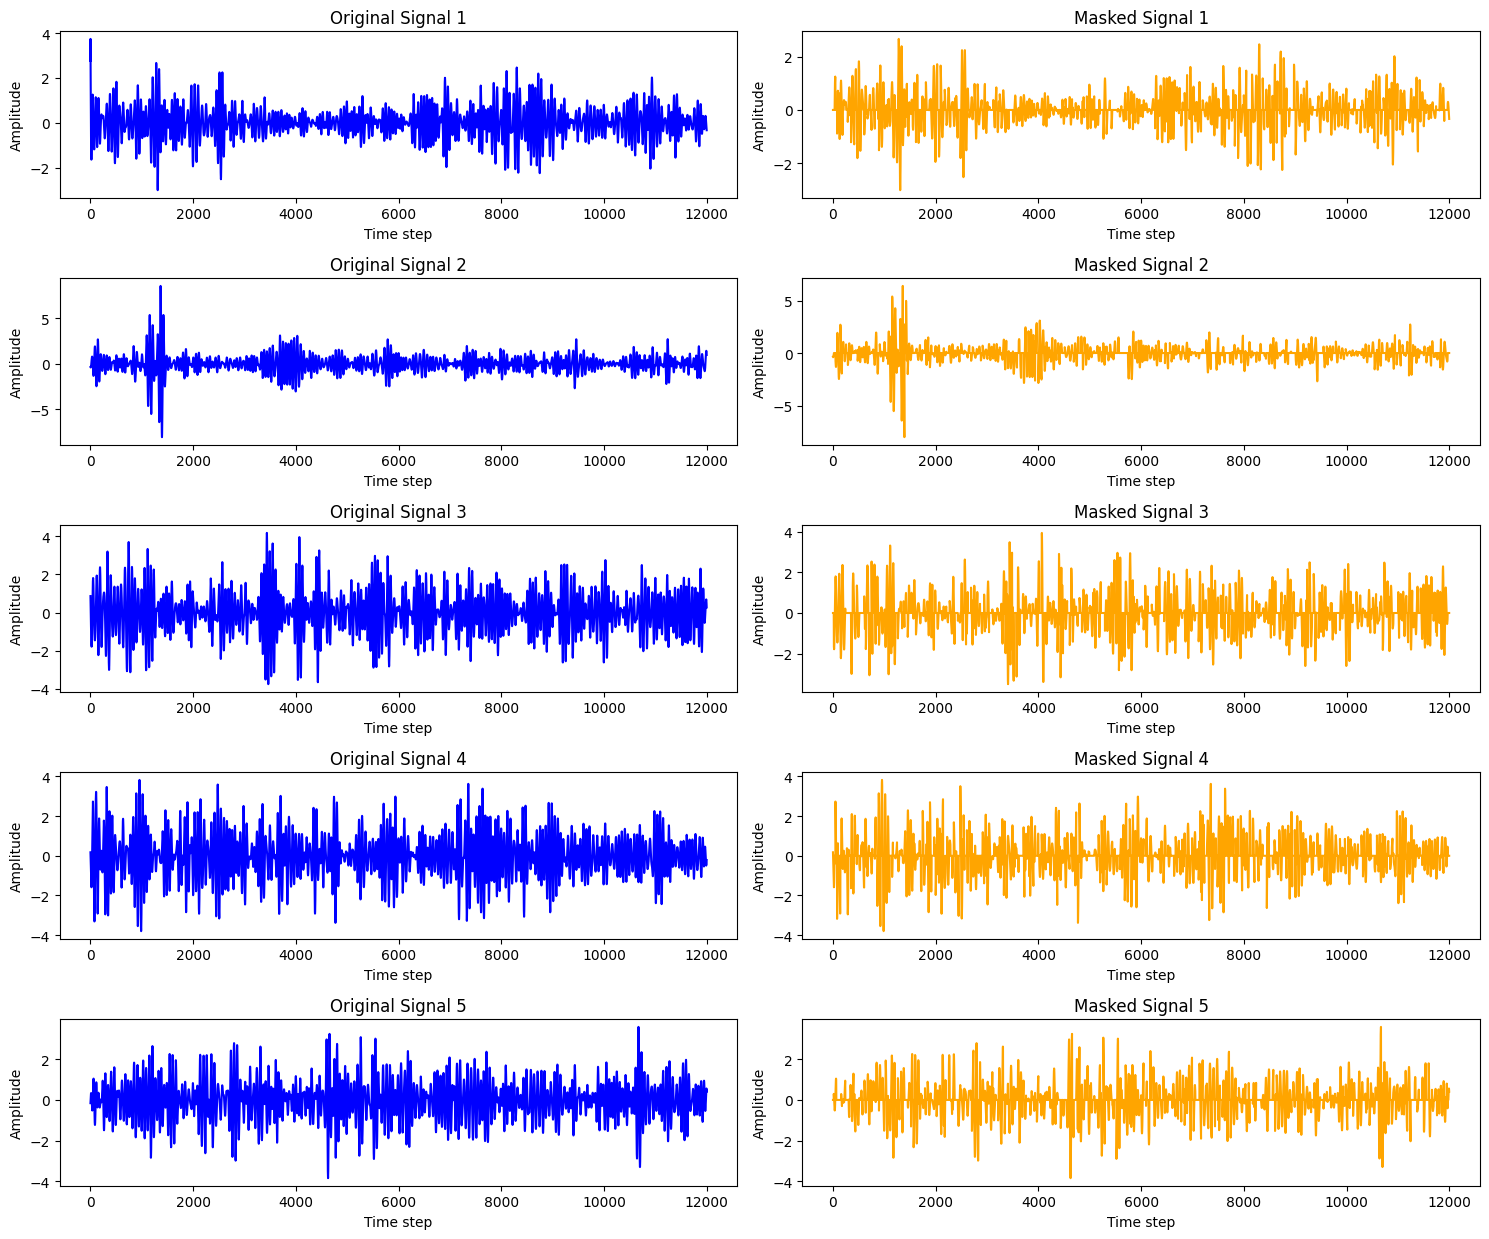

In [60]:
import matplotlib.pyplot as plt

def plot_masked_examples(original, masked, num_examples=5):
    plt.figure(figsize=(15, num_examples * 2.5))
    
    for i in range(num_examples):
        # Original signal
        plt.subplot(num_examples, 2, 2*i + 1)
        plt.plot(original[i], color='blue')
        plt.title(f"Original Signal {i+1}")
        plt.xlabel("Time step")
        plt.ylabel("Amplitude")

        # Masked signal
        plt.subplot(num_examples, 2, 2*i + 2)
        plt.plot(masked[i], color='orange')
        plt.title(f"Masked Signal {i+1}")
        plt.xlabel("Time step")
        plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()
plot_masked_examples(windows, masked_windows, num_examples=5)


In [61]:
class ConvNeXtBlock1D(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # Modify groups dynamically to match the input channels
        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)  # Depthwise conv
        self.norm = nn.LayerNorm(dim)
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # Pointwise conv1 (expand)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)  # Pointwise conv2 (project)

    def forward(self, x):
        shortcut = x
        x = self.dwconv(x)  # (B, C, L)
        x = x.permute(0, 2, 1)  # (B, L, C) for LayerNorm
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x + shortcut.permute(0, 2, 1)
        return x.permute(0, 2, 1)  # (B, C, L)


In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCMAE(nn.Module):
    def __init__(self, dim, num_blocks=3, hidden_dim=64):
        super(FCMAE, self).__init__()

        self.encoder = nn.Sequential(
            *[ConvNeXtBlock1D(dim) for _ in range(num_blocks)]
        )
        
        # Decoder architecture: reverse of encoder, we use Conv1D for upsampling
        self.decoder = nn.Sequential(
            *[self._make_decoder_block(dim, hidden_dim) for _ in range(num_blocks)]
        )

        # Final convolution layer to map the output back to the input shape
        self.final_conv = nn.Conv1d(dim, 1, kernel_size=1)  # Back to 1D output

    def _make_decoder_block(self, dim, hidden_dim):
        return nn.Sequential(
            nn.ConvTranspose1d(dim, hidden_dim, kernel_size=4, stride=2, padding=1),
            nn.GELU(),
            nn.ConvTranspose1d(hidden_dim, dim, kernel_size=4, stride=2, padding=1),
            nn.GELU(),
        )

    def forward(self, x):
        # Pass input through encoder
        encoded = self.encoder(x)
        
        # Pass encoded features through decoder
        decoded = self.decoder(encoded)
        
        # Final layer to reconstruct the original signal
        return self.final_conv(decoded)

# Initialize the model
model = FCMAE(dim=64, num_blocks=3)
print(model)


FCMAE(
  (encoder): Sequential(
    (0): ConvNeXtBlock1D(
      (dwconv): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), groups=64)
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (pwconv1): Linear(in_features=64, out_features=256, bias=True)
      (act): GELU(approximate='none')
      (pwconv2): Linear(in_features=256, out_features=64, bias=True)
    )
    (1): ConvNeXtBlock1D(
      (dwconv): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), groups=64)
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (pwconv1): Linear(in_features=64, out_features=256, bias=True)
      (act): GELU(approximate='none')
      (pwconv2): Linear(in_features=256, out_features=64, bias=True)
    )
    (2): ConvNeXtBlock1D(
      (dwconv): Conv1d(64, 64, kernel_size=(7,), stride=(1,), padding=(3,), groups=64)
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (pwconv1): Linear(in_features=64, out_features=256, bias=T

In [63]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming masked_X_train, masked_X_val, and masked_X_test are your datasets
# Convert them to PyTorch tensors
masked_X_train_tensor = torch.tensor(masked_X_train, dtype=torch.float32)
masked_X_val_tensor = torch.tensor(masked_X_val, dtype=torch.float32)
masked_X_test_tensor = torch.tensor(masked_X_test, dtype=torch.float32)

# Add a channel dimension (for univariate data)
masked_X_train_tensor = masked_X_train_tensor.unsqueeze(1)  # Shape: [1240, 1, 12000]
masked_X_val_tensor = masked_X_val_tensor.unsqueeze(1)  # Shape: [124, 1, 12000] (example)
masked_X_test_tensor = masked_X_test_tensor.unsqueeze(1)  # Shape: [124, 1, 12000] (example)

# Create TensorDataset for each set
train_dataset = TensorDataset(masked_X_train_tensor)
val_dataset = TensorDataset(masked_X_val_tensor)
test_dataset = TensorDataset(masked_X_test_tensor)

# Define the batch size
batch_size = 32

# Create DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for validation
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffle for test

# Example: iterating through batches in train_loader, val_loader, and test_loader
for batch in train_loader:
    print("Training batch shape:", batch[0].shape)  # Shape: [32, 1, 12000]

for batch in val_loader:
    print("Validation batch shape:", batch[0].shape)  # Shape: [32, 1, 12000]

for batch in test_loader:
    print("Test batch shape:", batch[0].shape)  # Shape: [32, 1, 12000]


Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape: torch.Size([32, 1, 12000])
Training batch shape

In [64]:
# Define the model
model = FCMAE(dim=64, num_blocks=3)

# Set up the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
masked_X_train_tensor = masked_X_train_tensor.to(device)
masked_X_val_tensor = masked_X_val_tensor.to(device)
masked_X_test_tensor = masked_X_test_tensor.to(device)


In [65]:
# Example training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Zero the gradients

    # Forward pass: get model output on masked input
    output = model(masked_X_train_tensor)
    
    # Compute the reconstruction loss
    loss = criterion(output, masked_X_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print the loss every few epochs
    if (epoch + 1) % 2 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")


RuntimeError: Given groups=64, weight of size [64, 1, 7], expected input[1240, 1, 12000] to have 64 channels, but got 1 channels instead